In [1]:
# Import niezbędnych bibliotek, oraz zdjęcia przykładowego:

In [2]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np


im = plt.imread('zdjecia/3.jpg')


plt.figure(figsize=(10,10))
plt.imshow(im, cmap="gray")
plt.axis('off')
plt.show()

<Figure size 1000x1000 with 1 Axes>

In [3]:
#zmianna koloru na skalę szarości

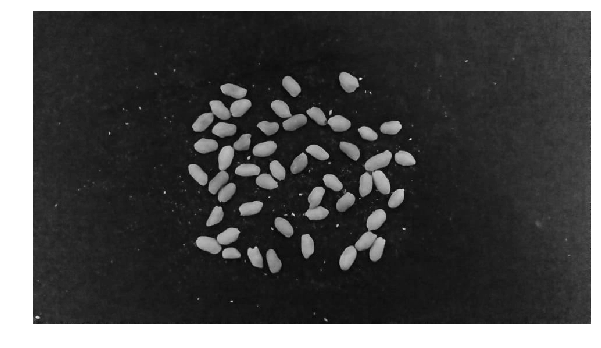

In [4]:
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(10,10))
plt.imshow(gray, cmap="gray")
plt.axis('off')
plt.show()

In [5]:
#Funkcja pokazująca 2 obrazy:

In [6]:
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(20,20)):
    
    import matplotlib.pyplot as plt
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

In [7]:
# Prezentacja w postaci wykresu liniowego oraz słupkowego dla obrazu z wewnętrzną reprezentacją 
# luminancji w zakresie całkowitym jednobajtowym tj.  [0,255] 

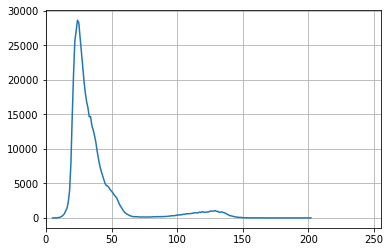

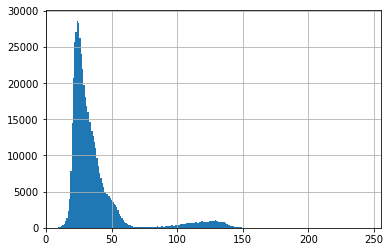

In [8]:
from skimage import exposure

histogram = exposure.histogram(gray, nbins=256)
hist, cbins = histogram

plt.plot(cbins, hist)
plt.xlim([-0.2, 255])
plt.grid()
plt.show()

plt.bar(cbins, hist, width=1)
plt.xlim([-0.2, 255])
plt.grid()
plt.show()

In [9]:
#poprawieni jakości - korekcja gamma

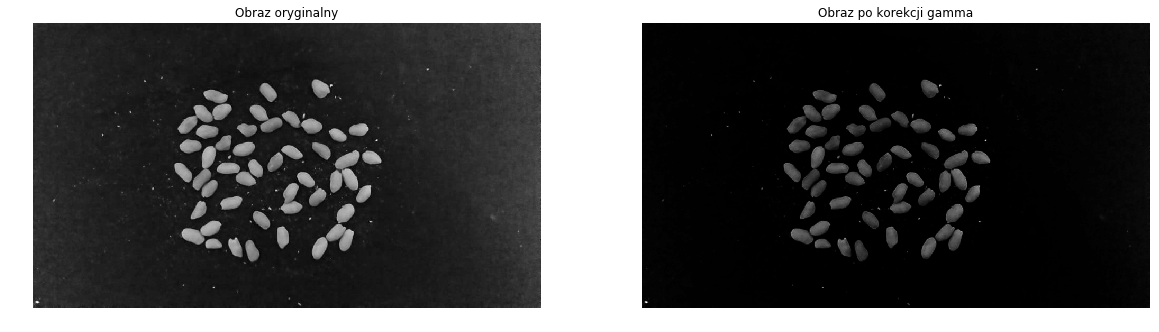

In [10]:
gamma = 2.5
gimf = exposure.adjust_gamma(gray, gamma=gamma)

show2imgs(gray, gimf, title1='Obraz oryginalny', title2='Obraz po korekcji gamma', size=(20,20))

In [11]:
# Binaryzacja OTSU

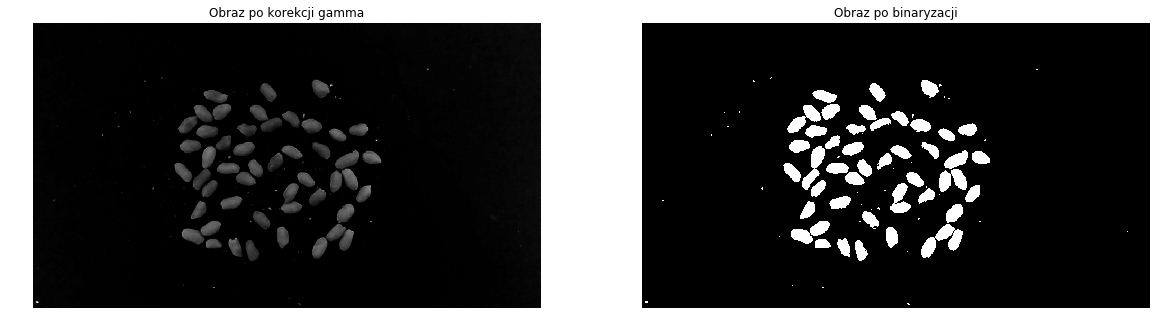

In [12]:
ret,thresh = cv2.threshold(gimf,0,255,cv2.THRESH_OTSU)

show2imgs(gimf, thresh, title1='Obraz po korekcji gamma', title2='Obraz po binaryzacji', size=(20,20))

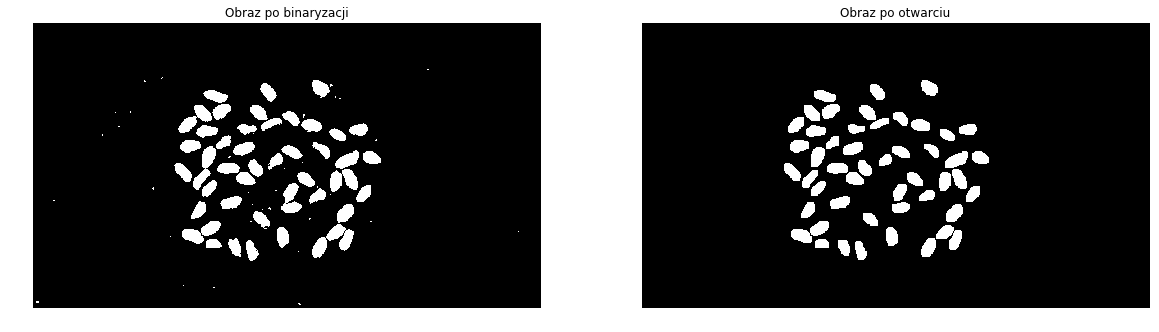

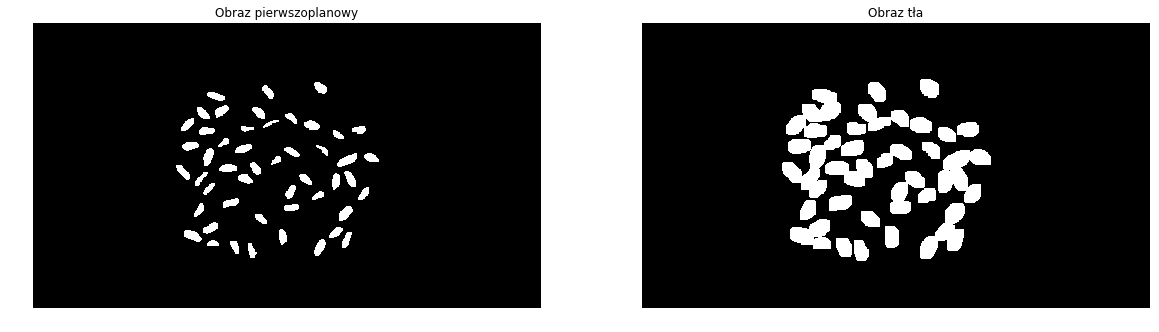

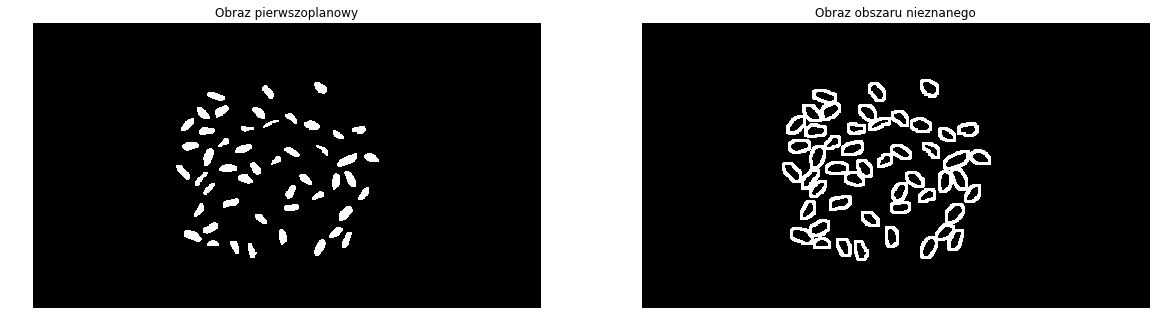

In [13]:
# otwarcie
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

# pewny obszar tła
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Pewny obszar pierwszplanowy (obiektów)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

# Obszar nieznany
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

show2imgs(thresh, opening, title1='Obraz po binaryzacji', title2='Obraz po otwarciu', size=(20,20))

show2imgs(sure_fg, sure_bg, title1='Obraz pierwszoplanowy', title2='Obraz tła', size=(20,20))

show2imgs(sure_fg, unknown, title1='Obraz pierwszoplanowy', title2='Obraz obszaru nieznanego', size=(20,20))

In [14]:
# wyznaczanie znaczników

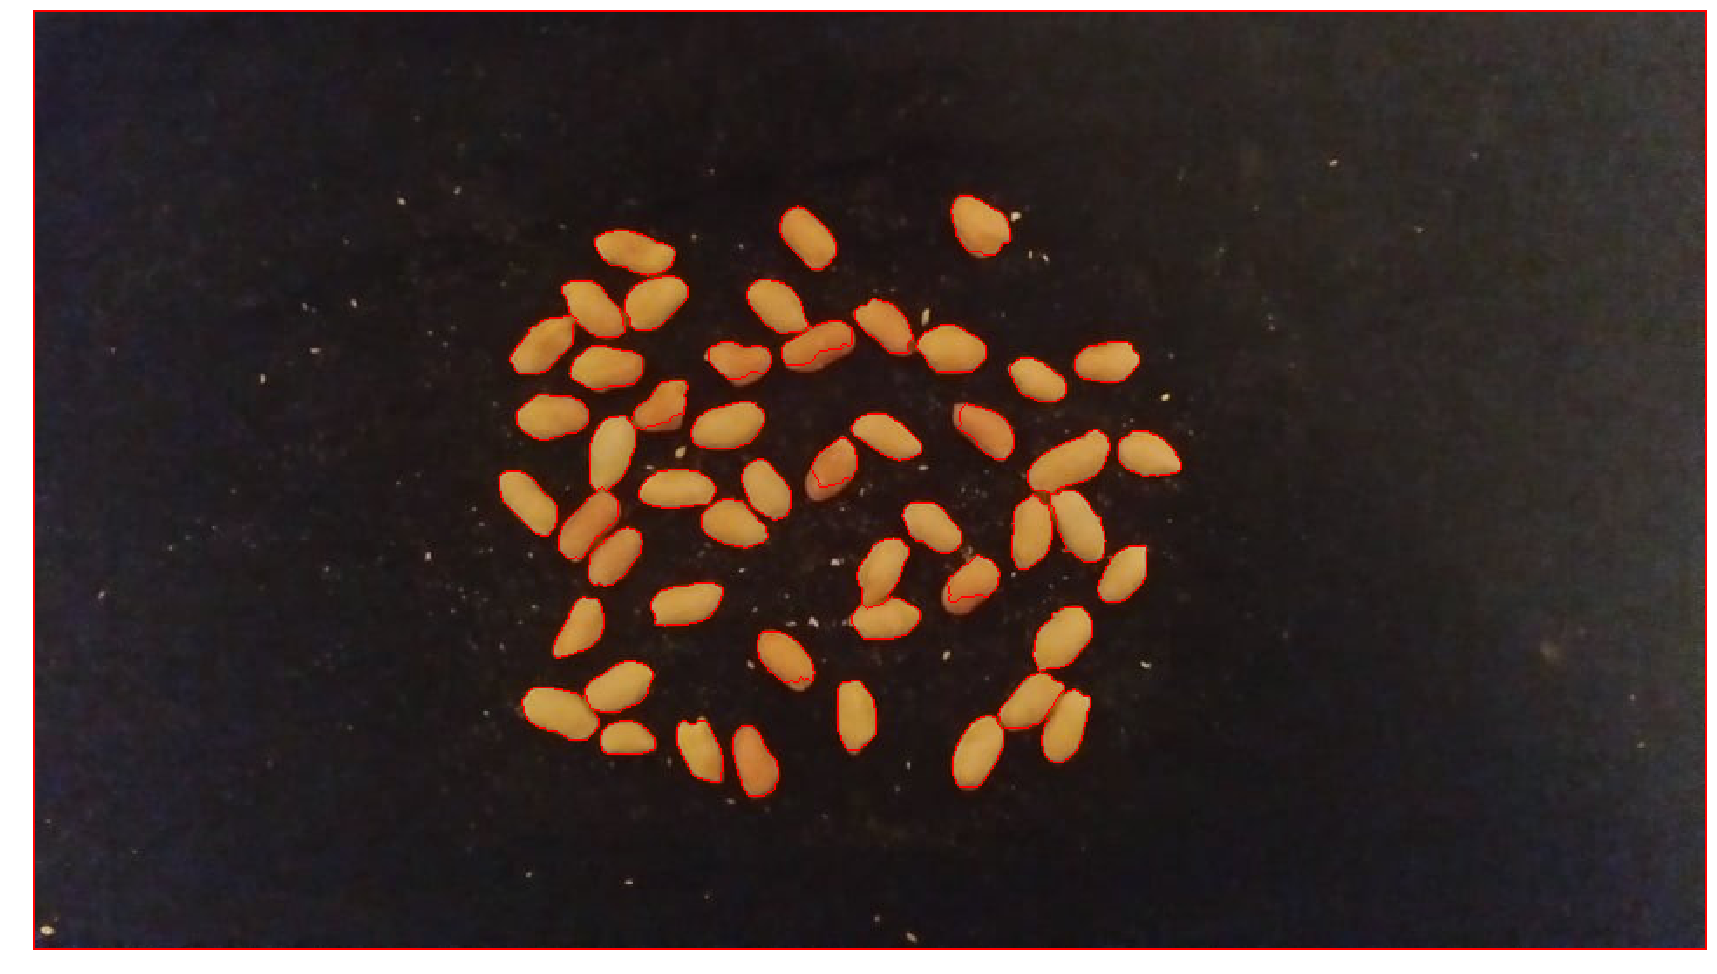

In [15]:
im.setflags(write=1)

# Etykietowanie znaczników
ret, markers = cv2.connectedComponents(sure_fg)

# Dodanie 1 do etykiet, dzięki czemu nasze tło będzie miało wartość 1, a nie 0
markers = markers+1

# Oznaczamy obszar nieznany jako 0
markers[unknown==255] = 0

markers = cv2.watershed(im,markers)
im[markers == -1] = [255,0,0]

plt.figure(figsize=(30,30))
plt.imshow(im, cmap="gray")
plt.axis('off')
plt.show()

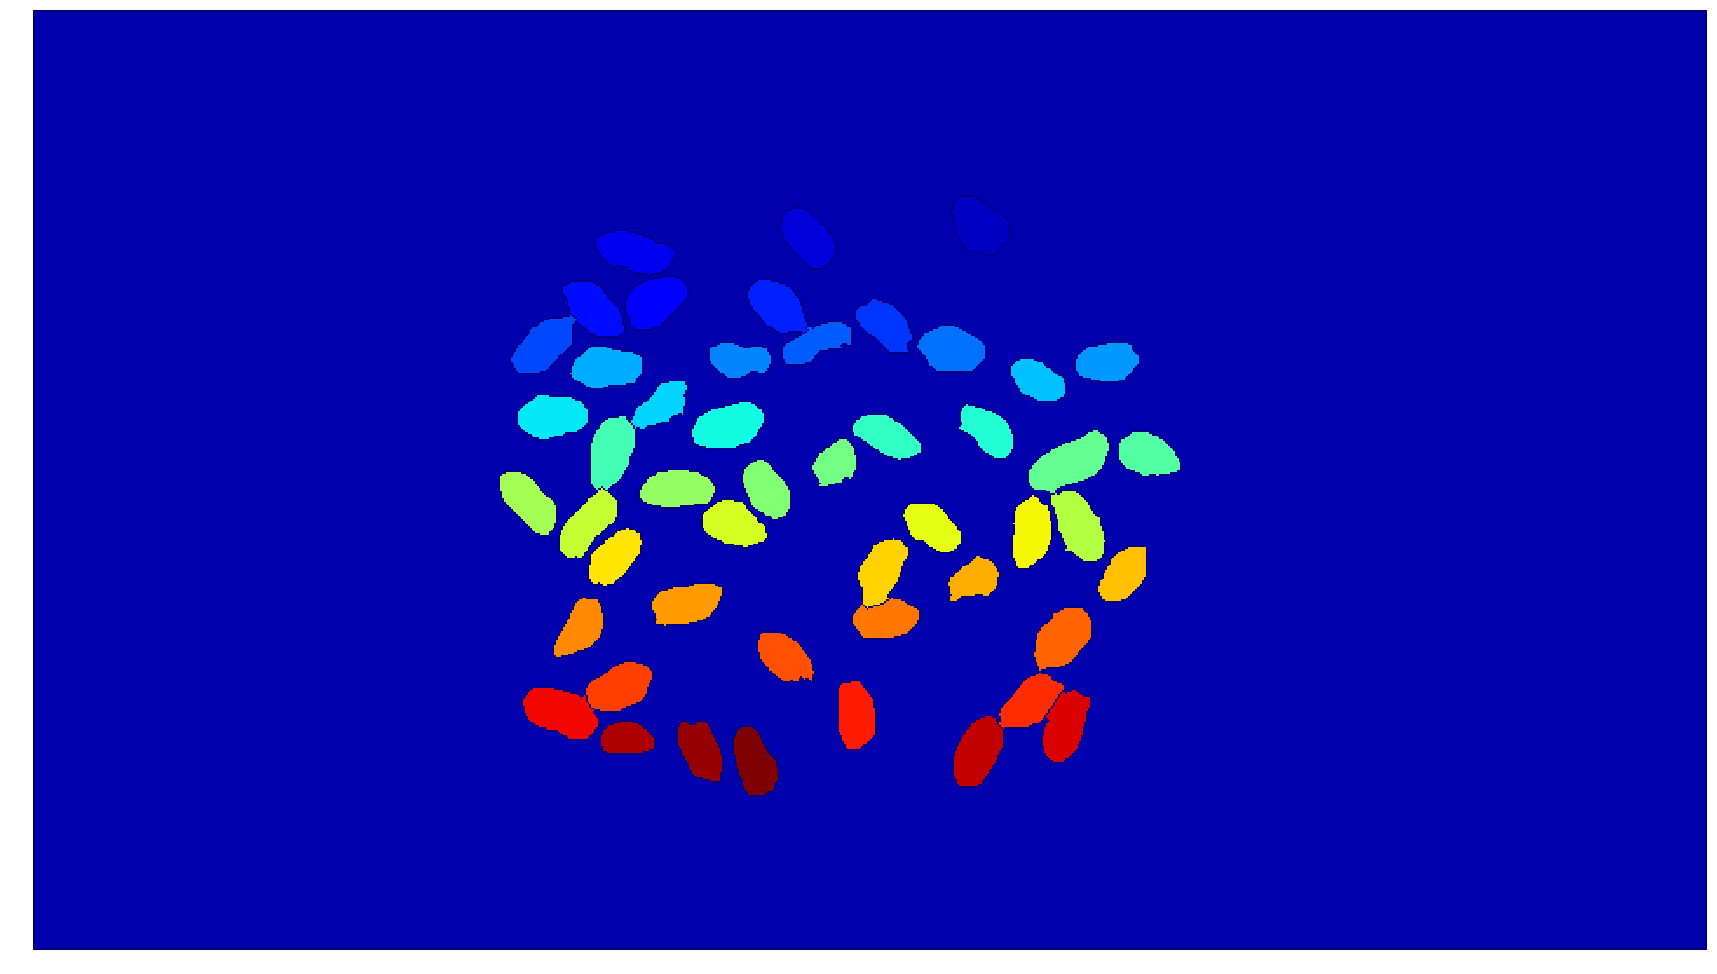

In [16]:
plt.figure(figsize=(30,30))
plt.imshow(markers, cmap="jet")
plt.axis('off')
plt.show()

In [17]:
# wyliczenie ilości ziaren

In [18]:
number_seeds = len(np.unique(markers))-2
print ('ilość obiektów : %i' % number_seeds)

ilość obiektów : 49


In [19]:
# Procentowy udział wyznaczonych obiektów ca całym zdjęciu, wyliczenie położenia środków ciężkości

In [20]:
from scipy import ndimage as ndi
label_objects, nb_labels = ndi.label(opening)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects]

In [21]:
no_of_object = 2

def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

cogs = []
for i in range(nb_labels):
    cogs.append(cog(label_objects, i+1))

def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points

#sumowanie punktów zajętych przez obiekty
suma=0
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    suma+=len(pts)
    
from skimage import feature, measure

#ilościowy i procentowy rozmiar zdjęcia
width, height = opening.shape[:2]
img_count = width*height
img_percent = img_count*100.0/width/height
print('Ilość punktów na zdjęciu wynosi:', img_count)
print('Procentowy udział: ',img_percent)

properties = measure.regionprops(label_objects)
label_areas = [int(prop.area) for prop in properties]

#ilościowy i procentowy rozmiar zdjęcia po odjęciu sumy punktów zajętych przez obiekty
imga_count = width*height-suma
imga_percent = imga_count*100.0/width/height
print('Ilość punktów na zdjęciu po odjęciu sumy punków zajmowanej przez obiekty:', imga_count)
print('Procentowy udział: ',imga_percent)

#Obliczenie udziału procentowego
procentx = img_percent - imga_percent
print ('Procentowy udział obiektów na zdjęciu:',procentx)

Ilość punktów na zdjęciu wynosi: 517440
Procentowy udział:  100.0
Ilość punktów na zdjęciu po odjęciu sumy punków zajmowanej przez obiekty: 486474
Procentowy udział:  94.01553803339517
Procentowy udział obiektów na zdjęciu: 5.984461966604826


In [22]:
#Naniesienie środków ciężkości na obraz

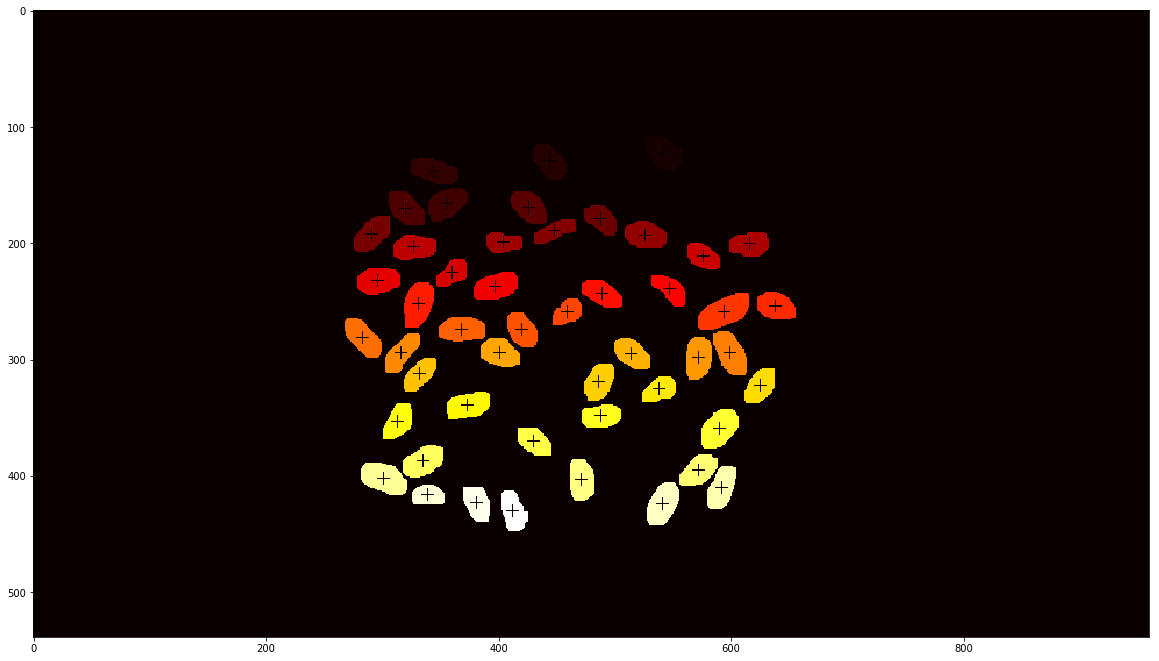

In [23]:
def drawMarkers(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-5, y+6):
            image[j,x] = 0
        for i in range(x-5, x+6):
            image[y,i] = 0
            
    return image


lo = drawMarkers(label_objects, cogs)
plt.figure(figsize=(20,20))
plt.imshow(lo,cmap='hot')
plt.show()

In [24]:
#przedstawienie liczby punktów i środków ciężkości badanych obiektów

In [25]:
def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]


for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    print('Liczba punktow: ',len(pts),' Srodek ciezkosci: ', cog2(pts) )

Liczba punktow:  703  Srodek ciezkosci:  [122.42532005689901, 542.7724039829303]
Liczba punktow:  636  Srodek ciezkosci:  [129.8993710691824, 444.0566037735849]
Liczba punktow:  702  Srodek ciezkosci:  [138.0014245014245, 344.85612535612535]
Liczba punktow:  716  Srodek ciezkosci:  [166.16759776536313, 355.6480446927374]
Liczba punktow:  674  Srodek ciezkosci:  [170.35014836795253, 320.5519287833828]
Liczba punktow:  655  Srodek ciezkosci:  [169.1236641221374, 426.4732824427481]
Liczba punktow:  523  Srodek ciezkosci:  [179.61376673040152, 488.33078393881453]
Liczba punktow:  673  Srodek ciezkosci:  [192.1263001485884, 291.3967310549777]
Liczba punktow:  459  Srodek ciezkosci:  [189.62745098039215, 448.3289760348584]
Liczba punktow:  691  Srodek ciezkosci:  [193.16353111432707, 526.5238784370478]
Liczba punktow:  446  Srodek ciezkosci:  [199.52466367713004, 404.0515695067265]
Liczba punktow:  589  Srodek ciezkosci:  [200.95076400679116, 616.1035653650255]
Liczba punktow:  653  Srodek c

In [26]:
#wyliczenie wariancji środków ciężkości dla wszystkich obiektów

In [27]:
def x(points):
    mx=0
    for (y,x) in points:
        mx = mx + x
    mx = mx/len(points)
    
    return mx

sumx=0
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    sumx+=x(pts)

#print(sumx/nb_labels)

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    warx=((x(pts)-(sumx/nb_labels))**2)/(sumx/nb_labels)
    
def y(points):
    my=0
    for (y,x) in points:
        my = my + y
    my = my/len(points)
    
    return my

sumy=0
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    sumy+=y(pts)
    
#print(sumy/nb_labels)

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    wary=((x(pts)-(sumy/nb_labels))**2)/(sumy/nb_labels)

print('Wariancja srodków ciężkości: ',[wary, warx])

Wariancja srodków ciężkości:  [62.951486382287605, 2.3989447263982706]
